# CW Attack Example

TJ Kim <br />
1.28.21

### Summary: 
Implement CW attack on toy network example given in the readme of the github. <br />
https://github.com/tj-kim/pytorch-cw2?organization=tj-kim&organization=tj-kim

A dummy network is made using CIFAR example. <br />
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Build Dummy Pytorch Network

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Download a few classes from the dataset.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Show a few images from the dataset.

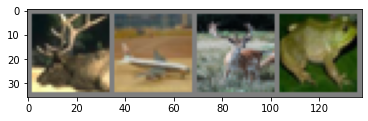

 deer plane  deer  frog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define a NN.

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Define loss and optimizer

In [5]:
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the Network

In [6]:

train_flag = False
PATH = './cifar_net.pth'

if train_flag:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
else:
    net.load_state_dict(torch.load(PATH))

Save Existing Network.

In [7]:
if train_flag:
    torch.save(net.state_dict(), PATH)

Test Acc.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


### C&W Attack

Perform attack on toy network.

Before running the example code, we have to set the following parameters:

- dataloader
- mean
- std 

The mean and std are one value per each channel of input

In [9]:
dataloader = trainloader
mean = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)

In [10]:
import torch
import cw

inputs_box = (min((0 - m) / s for m, s in zip(mean, std)),
              max((1 - m) / s for m, s in zip(mean, std)))
# an untargeted adversary
adversary = cw.L2Adversary(targeted=False,
                           confidence=0.0,
                           search_steps=10,
                           box=inputs_box,
                           optimizer_lr=5e-4)

inputs, targets = next(iter(dataloader))
adversarial_examples = adversary(net, inputs, targets, to_numpy=False)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()

# a targeted adversary
adversary = cw.L2Adversary(targeted=True,
                           confidence=0.0,
                           search_steps=10,
                           box=inputs_box,
                           optimizer_lr=5e-4)

inputs, _ = next(iter(dataloader))
# a batch of any attack targets
attack_targets = torch.ones(inputs.size(0), dtype = torch.long) * 3
adversarial_examples = adversary(net, inputs, attack_targets, to_numpy=False)
assert isinstance(adversarial_examples, torch.FloatTensor)
assert adversarial_examples.size() == inputs.size()

Using scale consts: [0.001, 0.001, 0.001, 0.001]
batch [0] loss: 0.002361125312745571
batch [10] loss: 0.0026217298582196236
batch [20] loss: 0.002423797035589814
batch [30] loss: 0.0023616841062903404
batch [40] loss: 0.0023606482427567244
batch [50] loss: 0.002359609818086028
batch [60] loss: 0.002358335768803954
batch [70] loss: 0.00235783401876688
batch [80] loss: 0.0023577541578561068
batch [90] loss: 0.002357742516323924
batch [100] loss: 0.002357700141146779
batch [110] loss: 0.0023576845414936543
batch [120] loss: 0.0023576836101710796
batch [130] loss: 0.002357680816203356
batch [140] loss: 0.0023576810490339994
batch [150] loss: 0.002357681281864643
batch [160] loss: 0.0023576817475259304
batch [170] loss: 0.0023576810490339994
batch [180] loss: 0.0023576815146952868
batch [190] loss: 0.0023576810490339994
batch [200] loss: 0.002357681980356574
Using scale consts: [0.0005, 0.0005, 0.01, 0.01]
batch [0] loss: 0.023547250777482986
batch [10] loss: 0.02334403246641159
batch [20]

batch [280] loss: 0.7746122479438782
batch [290] loss: 0.7747665643692017
batch [300] loss: 0.7746263146400452
batch [310] loss: 0.7748005986213684
batch [320] loss: 0.7746768593788147
batch [330] loss: 0.7748297452926636
batch [340] loss: 0.7747646570205688
batch [350] loss: 0.7748028635978699
batch [360] loss: 0.7745120525360107
batch [370] loss: 0.7746369242668152
batch [380] loss: 0.7747985124588013
batch [390] loss: 0.7744199633598328
batch [400] loss: 0.7745277285575867
batch [410] loss: 0.7747362852096558
batch [420] loss: 0.7748448252677917
batch [430] loss: 0.7745996713638306
batch [440] loss: 0.7745151519775391
batch [450] loss: 0.7747334241867065
batch [460] loss: 0.7748349905014038
batch [470] loss: 0.775144100189209
batch [480] loss: 0.7748696208000183
batch [490] loss: 0.7746285200119019
batch [500] loss: 0.7744593620300293
Using scale consts: [1.5625e-05, 1.5625e-05, 0.049375, 0.8875]
batch [0] loss: 0.7835591435432434
batch [10] loss: 0.7792426347732544
batch [20] loss:

batch [340] loss: 1.9697868824005127
batch [350] loss: 1.9764597415924072
batch [360] loss: 1.9698004722595215
batch [370] loss: 1.9661434888839722
batch [380] loss: 1.9661065340042114
batch [390] loss: 1.9696223735809326
batch [400] loss: 1.9740419387817383
batch [410] loss: 1.9738352298736572
batch [420] loss: 1.973207950592041
batch [430] loss: 1.9693353176116943
batch [440] loss: 1.9641797542572021
batch [450] loss: 1.9675893783569336
batch [460] loss: 1.9654192924499512
batch [470] loss: 1.9701522588729858
batch [480] loss: 1.9683369398117065
batch [490] loss: 1.9741967916488647
batch [500] loss: 1.970823049545288
batch [510] loss: 1.9731776714324951
batch [520] loss: 1.9649906158447266
batch [530] loss: 1.9703929424285889
batch [540] loss: 1.9683380126953125
batch [550] loss: 1.963368535041809
batch [560] loss: 1.967734932899475
batch [570] loss: 1.9677284955978394
batch [580] loss: 1.9671534299850464
batch [590] loss: 1.9680250883102417
batch [600] loss: 1.9671636819839478
batch